# Introduction

This notebook presents **Keypoint Detection** using a **CNN** on the [CAT](https://www.kaggle.com/crawford/cat-dataset) dataset.

**Resources**

* [Cat Hipsterizer](https://github.com/kairess/cat_hipsterizer) - inspiration for this notebook
* [CAT (Kaggle)](https://www.kaggle.com/crawford/cat-dataset) - dataset used in this notebook
* [CAT (original)](https://archive.org/details/CAT_DATASET) - internet archive link to original data

# Imports

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import PIL
import PIL.ImageDraw

Limit TensorFlow GPU memory usage

In [2]:
import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True)  # init TF ...
config=tf.ConfigProto(gpu_options=gpu_options)  # w/o taking ...
with tf.Session(config=config): pass            # all GPU memory

# Configuration

Point this to dataset directory, folder should contain CAT_00, CAT_01 and so on.

In [3]:
dataset_location = '/home/marcin/Datasets/cat-dataset/cats/'

# Helpers

In [4]:
def plot_images(indices, images, features):
    def draw_keypoints(img, keypoints, r=2, c='red'):
        """Draw keypoints on PIL image"""
        draw = PIL.ImageDraw.Draw(img)
        for x, y in keypoints:
            draw.ellipse([x-r, y-r, x+r, y+r], c)
        return img
    
    _, iw, ih, _ = images.shape
    assert iw == ih
    

    tmp_images = images[indices]
    tmp_features = features[indices]
    predictions = model.predict(tmp_features)
    kps = (predictions * (iw // 2)) + (iw // 2)

    _, axes = plt.subplots(nrows=1, ncols=len(indices), figsize=[12,4])
    if len(indices) == 1: axes = [axes]

    for i, idx in enumerate(indices):
        img = PIL.Image.fromarray(images[idx])
        axes[i].imshow(draw_keypoints(img, kps[i]))
        axes[i].axis('off')
    
    plt.show()

# Load Dataset

In this section we:

* load images and keypoints from folder structure
* resize to 224x224 and save into numpy .npz file

Subfolders within dataset

In [5]:
folders_all = ['CAT_00', 'CAT_01', 'CAT_02', 'CAT_03', 'CAT_04', 'CAT_05', 'CAT_06']

Get paths to all images

In [6]:
def build_image_files_list(folders):
    image_files_list = []
    for folder in folders:
        wild_path = os.path.join(dataset_location, folder, '*.jpg')
        image_files_list.extend(sorted(glob.glob(wild_path)))
    return image_files_list

In [7]:
image_paths_all = build_image_files_list(folders_all)

In [8]:
print('Nb images:', len(image_paths_all))
image_paths_all[:3]

Nb images: 9997


['/home/marcin/Datasets/cat-dataset/cats/CAT_00/00000001_000.jpg',
 '/home/marcin/Datasets/cat-dataset/cats/CAT_00/00000001_005.jpg',
 '/home/marcin/Datasets/cat-dataset/cats/CAT_00/00000001_008.jpg']

Helper to load keypoint data from *.cat* files

In [9]:
def load_keypoints(path):    
    """
        .cat is a single-line text file in format: 'nb_keypoints x1, y1, x2, y2, ...'
    """
    with open(path, 'r') as f:
        line = f.read().split()  # [nb_keypoints, x1, y1, x2, y2, ...]
    keypoints_nb = int(line[0])  # int
    keypoints_1d = np.array(line[1:], dtype=int)  # np.ndarray, [x1, y1, x2, y2, ...]
    keypoints_xy = keypoints_1d.reshape((-1, 2))  # np.ndarray, [[x1, y1], [x2, y2], ...]
    assert keypoints_nb == len(keypoints_xy)
    assert keypoints_nb == 9                # always nine keypoints, eyes, nose, two ears
    return keypoints_xy                     # np.ndarray, [[x1, y1], [x2, y2], ...]

Helper to draw keypoints on the image

In [10]:
def draw_keypoints(img, keypoints, r=2, c='red'):
    """Draw keypoints on PIL image"""
    draw = PIL.ImageDraw.Draw(img)
    for x, y in keypoints:
        draw.ellipse([x-r, y-r, x+r, y+r], c)
    return img

Open single image and load corresponding keypoints

In [11]:
example_path = image_paths_all[0]
img = PIL.Image.open(example_path)
kps = load_keypoints(example_path+'.cat')

Show example keypoints

In [12]:
display(kps)

array([[175, 160],
       [239, 162],
       [199, 199],
       [149, 121],
       [137,  78],
       [166,  93],
       [281, 101],
       [312,  96],
       [296, 133]])

Show example image

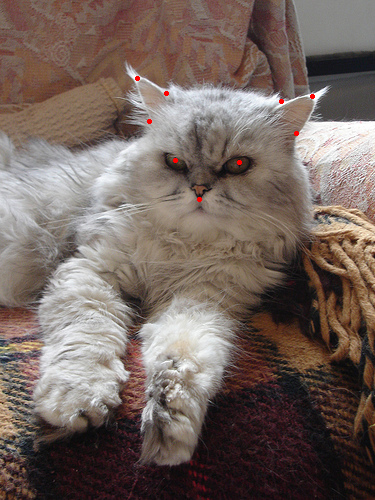

In [13]:
display(draw_keypoints(img.copy(), kps))

Helper to scale image and keypoints

In [14]:
def scale_img_kps(image, keypoints, target_size):
    width, height = image.size
    ratio_w = width / target_size
    ratio_h = height / target_size
    
    image_new = image.resize((target_size, target_size), resample=PIL.Image.LANCZOS)
    
    keypoints_new = np.zeros_like(keypoints)
    keypoints_new[range(len(keypoints_new)), 0] = keypoints[:,0] / ratio_w
    keypoints_new[range(len(keypoints_new)), 1] = keypoints[:,1] / ratio_h
    
    return image_new, keypoints_new

Test it

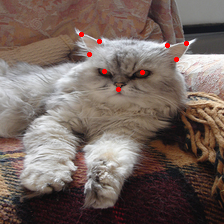

In [15]:
img2, kps2 = scale_img_kps(img, kps, target_size=224)
display(draw_keypoints(img2.copy(), kps2))

Helper to load and transform both input image and keypoints

In [16]:
def load_image_keypoints(image_path, keypoints_path, target_size):
    image = PIL.Image.open(image_path)
    keypoints = load_keypoints(keypoints_path)
    image_new, keypoints_new = scale_img_kps(image, keypoints, target_size)
    return image, keypoints, image_new, keypoints_new

Show couple more examples

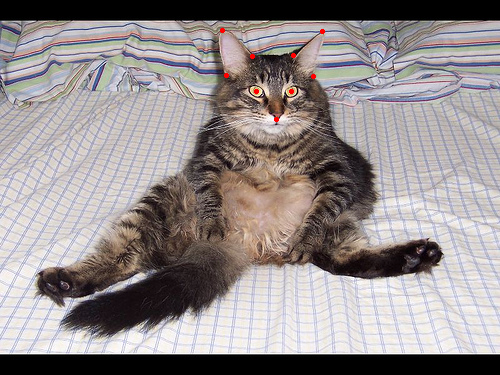

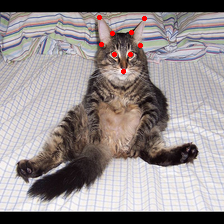

In [17]:
idx = 21

image, keypoints, image_new, keypoints_new = load_image_keypoints(
    image_paths_all[idx], image_paths_all[idx]+'.cat', target_size=224)
display(draw_keypoints(image.copy(), keypoints))
display(draw_keypoints(image_new.copy(), keypoints_new))

**Preprocess Images**

In [18]:
images_list = []
keypoints_list = []
for i, image_path in enumerate(image_paths_all):
    _, _, image_new, keypoints_new = \
        load_image_keypoints(image_path, image_path+'.cat', target_size=224)
    
    image_arr = np.array(image_new)
    # assert image_arr.shape == (224, 224, 3)
    # assert 0 <= image_arr.min() <= 255

    images_list.append(image_arr)
    keypoints_list.append(keypoints_new)
    
    if i % 1000 == 0:
        print('i:', i)
        
images = np.array(images_list)
keypoints = np.array(keypoints_list)

i: 0
i: 1000
i: 2000
i: 3000
i: 4000
i: 5000
i: 6000
i: 7000
i: 8000
i: 9000


In [19]:
print('images.shape:', images.shape)
print('images.dtype:', images.dtype)
print('images.min()', images.min())
print('images.max()', images.max())

images.shape: (9997, 224, 224, 3)
images.dtype: uint8
images.min() 0
images.max() 255


Note that some keypoints are outside of image (e.g. when cat ear is cropped out)

In [20]:
print('keypoints.shape:', keypoints.shape)
print('keypoints.dtype:', keypoints.dtype)
print('keypoints.min()', keypoints.min())
print('keypoints.max()', keypoints.max())

keypoints.shape: (9997, 9, 2)
keypoints.dtype: int64
keypoints.min() -139
keypoints.max() 295


Sanity check

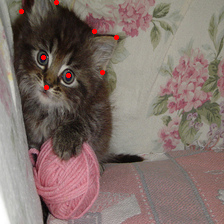

In [21]:
idx = 1

display(draw_keypoints(PIL.Image.fromarray(images[idx]).copy(), keypoints[idx]))

**Save Data**

In [22]:
dataset_npz = os.path.join(dataset_location, 'cats_224.npz')
print(dataset_npz)

/home/marcin/Datasets/cat-dataset/cats/cats_224.npz


In [23]:
# np.savez(dataset_npz, images=images, keypoints=keypoints)

# Preprocess, Bottleneck Features

In this section we:

* load 224x224 images and keypoints from .npz file
* apply normalization to images
* normalize keypoints to -1..1 range
* pass through model to get bottleneck features (unused in this notebook)
* save into second .npz file

Dataset file

In [24]:
dataset_npz = os.path.join(dataset_location, 'cats_224.npz')
print(dataset_npz)

/home/marcin/Datasets/cat-dataset/cats/cats_224.npz


Load data

In [25]:
npzfile = np.load(dataset_npz)
images = npzfile['images']
keypoints = npzfile['keypoints']

**Choose Model**

Pick one of the models, preprocessing and normalization may depend on model picked.

Note that some setups use max pooling while other simply output last conv layer without pooling

In [26]:
model_name = 'mobilenetv2_max'
preprocess_function = tf.keras.applications.mobilenet_v2.preprocess_input
model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(224, 224, 3), alpha=1.0, include_top=False, pooling='max',
    weights='imagenet')  # output shape: (None, 1280)

Instructions for updating:
Colocations handled automatically by placer.


In [27]:
# model_name = 'mobilenetv2'
# preprocess_function = tf.keras.applications.mobilenet_v2.preprocess_input
# model = tf.keras.applications.mobilenet_v2.MobileNetV2(
#     input_shape=(224, 224, 3), alpha=1.0, include_top=False,
#     weights='imagenet')  # output shape: (None, 7, 7, 1280)

In [28]:
# model_name = 'vgg16'
# preprocess_function = tf.keras.applications.vgg16.preprocess_input
# model = tf.keras.applications.vgg16.VGG16(
#     input_shape=(224, 224, 3), include_top=False,
#     weights='imagenet')  # output shape: (None, 7, 7, 512)

In [29]:
# model_name = 'vgg19'
# preprocess_function = tf.keras.applications.vgg19.preprocess_input
# model = tf.keras.applications.vgg19.VGG19(
#     input_shape=(224, 224, 3), include_top=False,
#     weights='imagenet')  # output shape: (None, 7, 7, 512)

In [30]:
# model_name = 'xception'
# preprocess_function = tf.keras.applications.xception.preprocess_input
# model = tf.keras.applications.xception.Xception(
#     input_shape=(224, 224, 3), include_top=False,
#     weights='imagenet')  # output shape: (None, 7, 7, 2048)

In [31]:
# model_name = 'densenet201_max'
# preprocess_function = tf.keras.applications.densenet.preprocess_input
# model = tf.keras.applications.densenet.DenseNet201(
#     input_shape=(224, 224, 3), include_top=False, pooling='max',
#     weights='imagenet')  # (None, 1920)

**Preprocess**

Convert input into ImageNet format. This converts to float, scales and offsets to match distribution of ImageNet training data.

In [32]:
features = preprocess_function(images)
print('features.shape:', features.shape)
print('features.dtype:', features.dtype)
print('features.min()', features.min())
print('features.max()', features.max())

features.shape: (9997, 224, 224, 3)
features.dtype: float32
features.min() -1.0
features.max() 1.0


Compute bottleneck features

In [33]:
bottleneck = model.predict(features, batch_size=32, verbose=1)

9997/9997 [==============================] - 16s 2ms/sample


In [34]:
print('bottleneck.shape:', bottleneck.shape)
print('bottleneck.dtype:', bottleneck.dtype)
print('bottleneck.min()', bottleneck.min())
print('bottleneck.max()', bottleneck.max())

bottleneck.shape: (9997, 1280)
bottleneck.dtype: float32
bottleneck.min() -11.51719
bottleneck.max() 33.805138


Convert targets to range -1..1

In [35]:
targets = (keypoints - 112) / 112
print('targets.shape:', targets.shape)
print('targets.dtype:', targets.dtype)
print('targets.min()', targets.min())
print('targets.max()', targets.max())

targets.shape: (9997, 9, 2)
targets.dtype: float64
targets.min() -2.2410714285714284
targets.max() 1.6339285714285714


**Save Data**

In [36]:
processed_npz = os.path.join(dataset_location, 'processed_'+model_name+'.npz')
print(processed_npz)

/home/marcin/Datasets/cat-dataset/cats/processed_mobilenetv2_max.npz


In [37]:
# np.savez(processed_npz, features=features, targets=targets, bottleneck=bottleneck)

# Train End-to-End

In [5]:
model_name = 'mobilenetv2_max'

In [6]:
dataset_npz = os.path.join(dataset_location, 'cats_224.npz')
processed_npz = os.path.join(dataset_location, 'processed_'+model_name+'.npz')
print(dataset_npz)
print(processed_npz)

/home/marcin/Datasets/cat-dataset/cats/cats_224.npz
/home/marcin/Datasets/cat-dataset/cats/processed_mobilenetv2_max.npz


In [7]:
npzfile = np.load(dataset_npz)
images = npzfile['images']

npzfile = np.load(processed_npz)
features = npzfile['features']
targets = npzfile['targets']

Split into training and validation

In [8]:
split = 8000
train_images = images[:split]
train_features = features[:split]
train_targets = targets[:split]
valid_images = images[split:]
valid_features = features[split:]
valid_targets = targets[split:]

Define model

In [9]:
X_inputs = tf.keras.layers.Input(shape=(224, 224, 3))

mobilenetv2 = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(224, 224, 3), alpha=1.0, include_top=False,
    weights='imagenet', input_tensor=X_inputs, pooling='max')

X = tf.keras.layers.Dense(128, activation='relu')(mobilenetv2.layers[-1].output)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dense(18, activation='linear')(X)
X = tf.keras.layers.Reshape((9, 2))(X)

model = tf.keras.models.Model(inputs=X_inputs, outputs=X)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Custom callback for plotting

In [10]:
class CallbackPlot(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        pass

    def on_epoch_end(self, batch, logs={}):
        plot_images([10, 20, 30, 40, 50, 60], train_images, train_features)
        plot_images([10, 20, 30, 40, 50, 60], valid_images, valid_features)

Show some cats before training. Most probably there won't be any keypoints shown

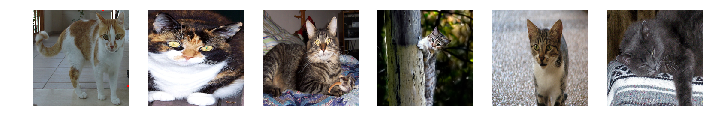

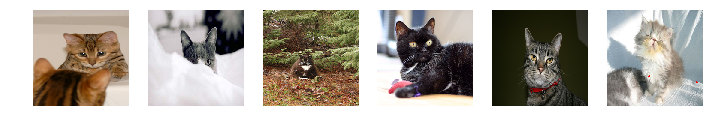

In [11]:
plot_images([10, 20, 30, 40, 50, 60], train_images, train_features)
plot_images([10, 20, 30, 40, 50, 60], valid_images, valid_features)

Run training

In [12]:
#
#   Callbacks
#

# tb_logdir = os.path.expanduser('~/logs/')
# tb_counter  = len([log for log in os.listdir(tb_logdir) if 'cats' in log]) + 1
# callback_tb = tf.keras.callbacks.TensorBoard(
#     log_dir=tb_logdir + 'cats' + '_' + str(tb_counter), )

callback_mc = tf.keras.callbacks.ModelCheckpoint(
    'model.h5', save_best_only=True, verbose=1)

callback_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, verbose=1)

# callback_plt = CallbackPlot()

#
#   Train
#
hist = model.fit(train_features, train_targets, epochs=50, batch_size=32, shuffle=True,
  validation_data=(valid_features, valid_targets),
  callbacks=[
             #callback_tb,
             callback_mc,
             callback_lr,
             #callback_plt,
            ]
)

Train on 8000 samples, validate on 1997 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/50
7968/8000 [============================>.] - ETA: 0s - loss: 0.2001
Epoch 00001: val_loss improved from inf to 0.19934, saving model to model.h5
8000/8000 [==============================] - 105s 13ms/sample - loss: 0.1995 - val_loss: 0.1993
Epoch 2/50
7968/8000 [============================>.] - ETA: 0s - loss: 0.0590
Epoch 00002: val_loss improved from 0.19934 to 0.09683, saving model to model.h5
8000/8000 [==============================] - 80s 10ms/sample - loss: 0.0590 - val_loss: 0.0968
Epoch 3/50
7968/8000 [============================>.] - ETA: 0s - loss: 0.0452
Epoch 00003: val_loss improved from 0.09683 to 0.06448, saving model to model.h5
8000/8000 [==============================] - 80s 10ms/sample - loss: 0.0452 - val_loss: 0.0645
Epoch 4/50
7968/8000 [============================>.] - ETA: 0s 

Epoch 32/50
7968/8000 [============================>.] - ETA: 0s - loss: 0.0019
Epoch 00032: val_loss improved from 0.00628 to 0.00571, saving model to model.h5
8000/8000 [==============================] - 77s 10ms/sample - loss: 0.0019 - val_loss: 0.0057
Epoch 33/50
7968/8000 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 00033: val_loss improved from 0.00571 to 0.00550, saving model to model.h5
8000/8000 [==============================] - 78s 10ms/sample - loss: 0.0018 - val_loss: 0.0055
Epoch 34/50
7968/8000 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 00034: val_loss improved from 0.00550 to 0.00546, saving model to model.h5
8000/8000 [==============================] - 78s 10ms/sample - loss: 0.0018 - val_loss: 0.0055
Epoch 35/50
7968/8000 [============================>.] - ETA: 0s - loss: 0.0017
Epoch 00035: val_loss improved from 0.00546 to 0.00524, saving model to model.h5
8000/8000 [==============================] - 78s 10ms/sample - loss: 0.

Plot loss during training

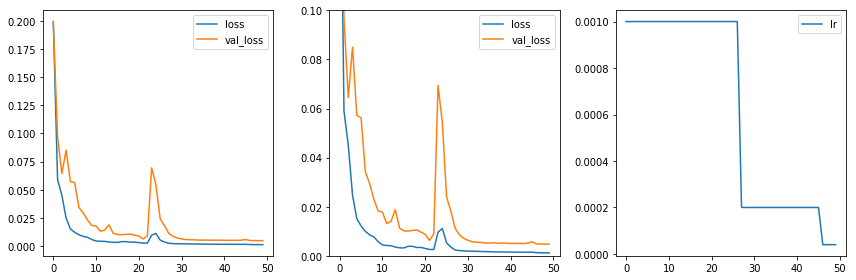

In [13]:
_, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
ax1.plot(hist.history['loss'], label='loss')
ax1.plot(hist.history['val_loss'], label='val_loss')
ax1.legend()

ax2.plot(hist.history['loss'], label='loss')
ax2.plot(hist.history['val_loss'], label='val_loss')
ax2.legend()
ax2.set_ylim(0, .1)

ax3.plot(hist.history['lr'], label='lr')
ax3.legend()

plt.tight_layout()
plt.show()

Show some cats from validation set - looks pretty good

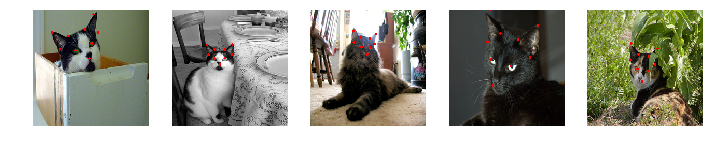

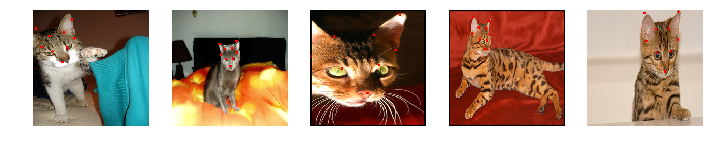

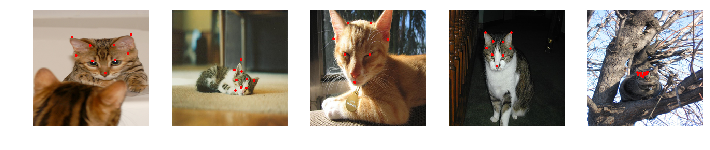

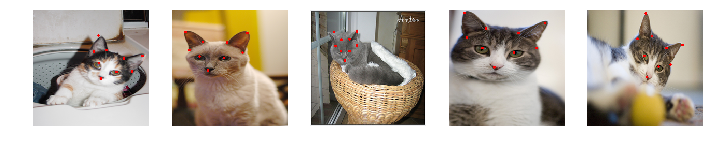

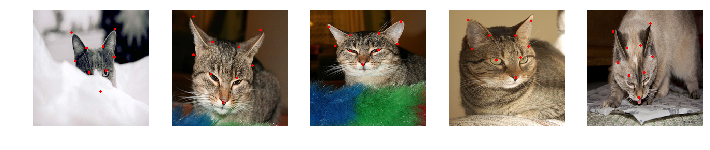

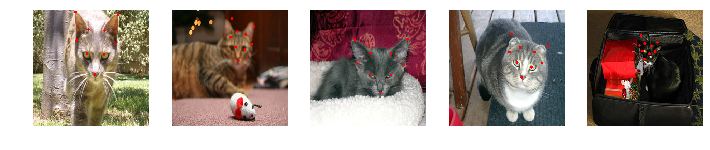

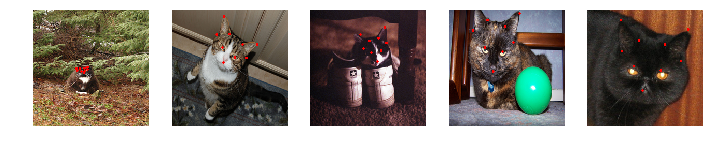

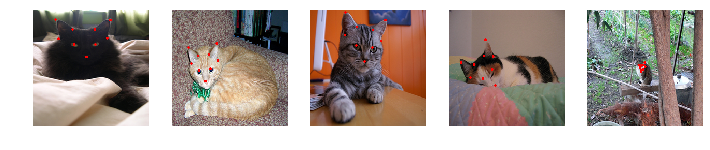

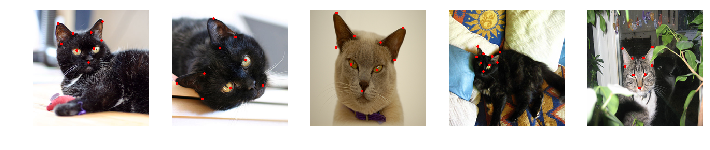

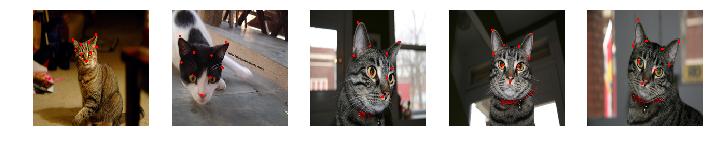

In [14]:
for j in range(0, 50, 5):
    plot_images([i for i in range(j, j+5)], valid_images, valid_features)

Investigate more closely

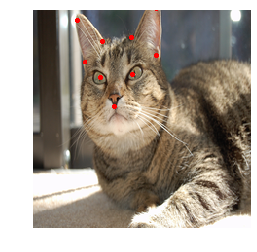

In [64]:
idx = 73
plot_images([idx], valid_images, valid_features)

# Train Regressor Only

This part trains only the regression part using bottleneck features

In [ ]:
model_name = 'mobilenetv2_max'

In [ ]:
dataset_npz = os.path.join(dataset_location, 'cats.npz')
processed_npz = os.path.join(dataset_location, 'processed_'+model_name+'.npz')
print(dataset_npz)
print(processed_npz)

In [ ]:
npzfile = np.load(dataset_npz)
images = npzfile['images']

npzfile = np.load(processed_npz)
features = npzfile['features']
targets = npzfile['targets']
bottleneck = npzfile['bottleneck']

Split into train and validation

In [ ]:
split = 8000
train_images = images[:split]
train_features = features[:split]
train_bottleneck = bottleneck[:split]
train_targets = targets[:split]
valid_images = images[split:]
valid_features = features[split:]
valid_bottleneck = bottleneck[split:]
valid_targets = targets[split:]

In [ ]:
train_bottleneck.shape

Build model

In [ ]:
X_inputs = tf.keras.layers.Input(shape=(7, 7, 1920))
X = tf.keras.layers.Flatten()(X_inputs)
X = tf.keras.layers.Dense(128, activation='relu')(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dense(18, activation='linear')(X)
X = tf.keras.layers.Reshape((9, 2))(X)

In [ ]:
model = tf.keras.models.Model(inputs=X_inputs, outputs=X)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')

In [ ]:
hist = model.fit(train_bottleneck, train_targets, epochs=50, batch_size=32, shuffle=True,
  validation_data=(valid_bottleneck, valid_targets),
)

In [23]:
def draw_keypoints(img, keypoints, r=2, c='red'):
    """Draw keypoints on PIL image"""
    draw = PIL.ImageDraw.Draw(img)
    for x, y in keypoints:
        draw.ellipse([x-r, y-r, x+r, y+r], c)
    return img

In [ ]:
def test_validate():

    indices = [12, 21, 31, 40]
    tmp_images = valid_images[indices]
    tmp_inputs = valid_bottleneck[indices]
    predictions = model.predict(tmp_inputs)

    _, axes = plt.subplots(nrows=1, ncols=len(indices), figsize=[12,4])

    for i, idx in enumerate(indices):
        img = PIL.Image.fromarray(valid_images[idx])
        kps = predictions[i] * 112 + 112
        axes[i].imshow(draw_keypoints(img, kps))
        
    plt.show()

In [ ]:
test_validate()